# Minichallenge 1 NPR
from Riccard Nef and Simon Luder


**Intro:** Ziel dieser Mini-Challenge ist es zwei  unterschiedliche Ansätze bei einem Text klassifikations Task auf ihre Performanz zu untersuchen und zu vergleichen. 
Wir wollen uns hierbei auf den Task der Sentimentanalyse bei Produktbewertungen konzentrieren. Bei einer Sensimentanalyse ist es das Ziel die Empfindung eines Textes zu erkennen, also ob der Verfasser eines entsprechenden Textes oder Aussage eine positive oder negative Haltung hervorbringt. 

Bei unserem ersten Ansatz nutzen wir mit tf-idf und anschliessendem Support-Vector-Machine Klassifizierer (SVM) ein herkömmliches Machine Learning Modell. 
Der zweite Ansatz fokussiert sich auf die Anwendung von Convolutional Neuronal Networks (CNN's) und somit auf ein deep Learning Modell.

**Zielmetriken:** Um die Güte der Klassifikation unserer Modelle zu evaluieren nutzen wir ein Set an Metriken, insbesondere Accuracy, Precision, Recall und F1-Score. 

<p>&nbsp;</p>

$$\text{Accuracy: } \displaystyle  \frac{\text{True Positive}+\text{True Negative}}{\text{True Positive}+\text{True Negative}+\text{False Positive}+\text{False Negative}}$$

<p>&nbsp;</p>

$$\text{Precision: } \displaystyle  \frac{\text{True Positive}}{\text{True Positive}+\text{False Positive}}$$

<p>&nbsp;</p>

$$\text{Recall: } \displaystyle \frac{\text{True Positive}}{\text{True Positive}+\text{False Negative}}$$

<p>&nbsp;</p>

$$\text{F1-Score: } \displaystyle \text{2} * \frac{\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}$$

<p>&nbsp;</p>

Das beste Modell wird anhand von Macro Accuracy und Macro F1-Score ermittelt. Hierbei handelt es sich um das arithmetische Mittel des jeweiligen Scores über alle Klassen.



**Dependencies:**

In [1]:
# import dependencies
import os
import gzip
import shutil
import requests

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd
import dask.dataframe as dd

import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split

# set seed
mc1seed = 42
import random
random.seed(mc1seed)

# ignore warnings
from warnings import simplefilter
simplefilter(action='ignore')

run_gridsearch = False

## 1.0 Datensatz

**Beschreibung der Daten:**
Die Daten stammen von Professor Julian McAuley und sind unter http://jmcauley.ucsd.edu/data/amazon/ verfügbar. Der komplette Datensatz beinhaltet gut 142.8 Millionen Produktbewertungen, welche zwischen dem Zeitraum von Mai 1996 bis Juli 2014 auf Amazon abgegeben wurden. Wir beschränken uns für diese Mini-Challenge auf das Subset `Toys and Games` welches im originalen Zustand gut 167,597 Bewertungen beinhaltet. 

**Werteskala:** Kunden können bei der Bewertung eines Produktes zwischen ein (1) und fünf (5) Sterne vergeben. Diese diskrete Sterne-Skala dient uns als Grundlage, um im weiteren Verlauf die Bewertungen in Positiv oder Negativ einzuteilen.

**Setup:** Für eine korrekte Ausführung des Notebooks muss der `reviews_Toys_and_Games_5.json.gz` Datensatz heruntergeladen werden, entpackt und anschliessend das `Toys_and_Games_5.json` im `src` Folder hinterlegt werden. Durch das Ausführen des Notebooks werden diese Schritte automatische durchgeführt.



In [2]:
source_url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz"
gz_file = "reviews_Toys_and_Games_5.json.gz"

path = "../../src/"
json_file = "Toys_and_Games_5.json"


# create src folder if doesn't exist
if not os.path.exists(path):
    os.makedirs(path)

# Downlod file if it doesnt exist
if not os.path.isfile(path + json_file):
    print("Download file...")
    response = requests.get(source_url, stream=True)
    if response.status_code == 200:
        with open(path + gz_file, 'wb') as f:
            f.write(response.raw.read())
            print("File download complete.")

    # unzip the file
    print("Unzip file...")
    with gzip.open(path + gz_file, 'rb') as f_in:
        with open(path + json_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print("File unzip complete.")

### 1.1.1 Installing ntlk data

In [3]:
# nltk.download()

### 1.1.2 Data import

Wir laden nun unseren Datensatz als pandas Dataframe.

In [4]:
try:
    df = pd.read_json("../../src/Toys_and_Games_5.json", lines=True)
except:
    print("Ups, something went wrong! Please make sure the Toys_and_Games_5.json dataset is in the src folder.")

In [5]:
print(f"Dataset contains {df.shape[0]} entries")
print(f"Name of Attributes: {df.columns.tolist()}")

Dataset contains 167597 entries
Name of Attributes: ['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'unixReviewTime', 'reviewTime']


### 1.1.3 Rating Proportions 

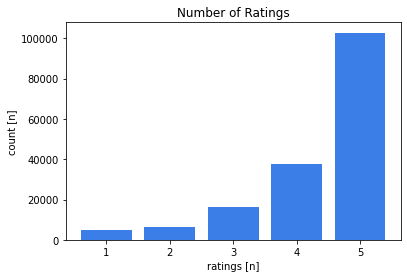

In [6]:
rating_count = df["overall"].value_counts()
plt.bar(rating_count.index, rating_count.values, color="#3B7EE7")
plt.title("Number of Ratings")
plt.xlabel("ratings [n]")
plt.ylabel("count [n]")
plt.show()

**Beschreibung:** Wir sehen um Barplot, dass sich überproportional viele Ratings mit einer 4 oder 5 im Datensatz befinden. Das muss in unseren Modellen entsprechend berücksichtigt werden. 

Wir möchten die Ratings nun in Positiv und Negativ einteilen. Dafür sehen wir Ratings von 1 bis 2 als schlecht, 3 als neutral und 4 bis 5 als gut an. In einem nächsten Schritt werden die neutralen Bewertungen entfernt und die restlichen binär eingeteilt. 

Dabei gilt: 
- 1 -> Gut
- 0 -> Schlecht

In [7]:
df_rating = df[["reviewText","overall"]].copy()
df_rating = df_rating[df_rating["overall"]!=3]
df_rating["category_binary"] = pd.cut(df_rating["overall"], 2, labels=[0, 1])
df_rating["category"] = pd.cut(df_rating["overall"], 2, labels=["Negative", "Positive"])
df_rating

,reviewText,overall,category_binary,category
0,I like the item pricing. My granddaughter want...,5,1,Positive
1,Love the magnet easel... great for moving to d...,4,1,Positive
2,Both sides are magnetic. A real plus when you...,5,1,Positive
3,Bought one a few years ago for my daughter and...,5,1,Positive
4,I have a stainless steel refrigerator therefor...,4,1,Positive
...,...,...,...,...
167592,This drone is very fun and super duarable. Its...,5,1,Positive
167593,This is my brother's most prized toy. It's ext...,5,1,Positive
167594,This Panther Drone toy is awesome. I definitel...,5,1,Positive
167595,This is my first drone and it has proven to be...,5,1,Positive


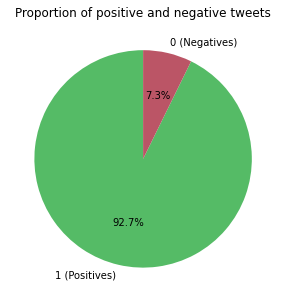

Nr of binary ratings:
Positive    140235
Negative     11005
Name: category, dtype: int64


In [8]:
sizes = df_rating['category'].value_counts()
labels = ['1 (Positives)', '0 (Negatives)']
colors = '#55BB66', '#BB5566'

# visualization
fig = plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Proportion of positive and negative tweets")
plt.show()

print("Nr of binary ratings:")
print(sizes)

Wir sehen nun die Verhältnisse nach der binären Einteilung der Ratings. Wir haben nun 140235 positive Ratings, was 92.3 Prozent aller Ratings entspricht und 11005 negative Ratings, was 7.3 Prozent aller Ratings entspricht. Für ein gutes Ergebnis unserer Klassifikation ist es wichtig, dass dieses Missverhältnis im Training der Modelle entsprechend berücksichtigt wird.

### 1.1.4 Document Lengths

Wir wollen nun einen Überblick über die Anzahl an Wörtern pro Dokument erhalten.

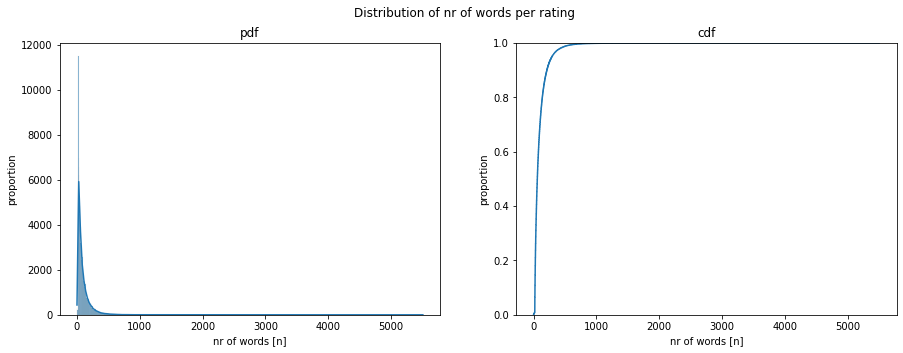

Quantiles of nr of words per rating:
0.00       0.0
0.25      32.0
0.50      60.0
0.75     119.0
1.00    5508.0
Name: reviewText, dtype: float64

Mean word count per rating:
97.27398836286697


In [9]:
sentence_length = df_rating["reviewText"].apply(str.split).apply(len)
filtered_sentence_length = sentence_length[(sentence_length >= 0) & (sentence_length < 500)]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(sentence_length, kde=True, ax=axes[0])
sns.ecdfplot(sentence_length, ax=axes[1])
fig.suptitle("Distribution of nr of words per rating")
axes[0].set_title("pdf")
axes[1].set_title("cdf")
axes[0].set_xlabel("nr of words [n]")
axes[1].set_xlabel("nr of words [n]")
axes[0].set_ylabel("proportion")
axes[1].set_ylabel("proportion")
plt.show()

print("Quantiles of nr of words per rating:")
print(sentence_length.quantile([0, .25, .5, .75, 1]))

print("\nMean word count per rating:")
print(sentence_length.mean())

**Beschreibung:** Wir sehen in der Visualisierung und der Verteilung, dass es Bewertungen mit sehr vielen Wörtern gibt. So haben 75 Prozent aller Bewertungen eine Länge 32 oder mehr Wörtern. Die Anzahl an Wörtern alleine ist jedoch nicht aussagekräftig über die Qualität der Trainingsdaten. So gibt es viele Wörter, die keine explizite positive oder negative Assoziation besitzen. Wir wollen deshalb in einem nächsten Abschnitt die Bewertungen so bereinigen, dass wir damit eine gute Datengrundlage für das Training unserer Modelle erreichen.

## 2.0 DataPipeline


### 2.1 Preprocessing

In diesem Abschnitt geht es darum, die Daten zu bereinigen. Da Tasks, bei denen es um die Verarbeitung natürlicher Sprache geht, normalerweise eine hohe Dimensionalität in den Daten vorherrscht, ist dieser Schritt essenziell, um relevante Features zu erhalten, die Feature Anzahl zu verringern. Dadurch kann die Effizienz und Qualität in unserer Klassifikation erhöht werden.

In [10]:
def remove_punctuation(sentence, p=None):
    '''Removes digits from a single sentence or a list of strings if words are in stop_words'''
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    if p:
        punctuations = p
    if isinstance(sentence, str):
        return sentence.translate(str.maketrans('', '', punctuations))
    if isinstance(sentence, list):
        sentence = [word for word in sentence if word not in punctuations]
    return sentence

def remove_digits(sentence):
    '''Removes digits from a single sentence or a list of strings'''
    if isinstance(sentence, str):
        return re.sub(r'[0-9]', '', sentence)
    if isinstance(sentence, list):
        return [re.sub(r'[0-9]', '', word) for word in sentence]

def remove_emojis(sentence):
    '''Removes emojis from a single sentence'''
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', sentence)

def remove_stop_words(sentence, stop_words):
    '''Removes stopwords from a list of strings sentence if words are in stop_words'''
    sentence = [word for word in sentence if word not in stop_words]
    return sentence

def print_sammples(series, idx):
    '''Prints samples from pandas series by a list of indices'''
    for i, sample in enumerate(data.iloc[check_samples]):
        print("'\033[1m' Sample {}: '\033[0m' {}\n".format(i+1, sample))

def lemmatize(sentence):
    "Lemmatizes a list of strings and returns as a list"
    return [WordNetLemmatizer().lemmatize(word) for word in sentence]

In einem ersten Schritt unserer Preprocessing Pipeline werden die Sätze aus unserem Dataframe mit `str.lower()` ausschliesslich zu Kleinbuchstaben transformiert. 
Danach werden mit der Funktion `remove_digits()` alle nummerischen Werte und mit `remove_punctuation()` alle Satzzeichen entfernt.

Nachfolgend werden zur Überprüfung drei Zufallssätze ausgegeben. Diese beinhalten nun keine Grossbuchstaben, Zahlen oder Satzzeichen mehr.

In [11]:
#set seed 
random.seed(mc1seed)

data = df_rating["reviewText"]

# convert everything to string
data = data.apply(str)

# convert to lowercase
data = data.apply(str.lower)

# remove digits
data = data.apply(remove_digits)

# remove punctuations
data = data.apply(remove_punctuation)

# print samples
check_samples = random.sample(range(1, len(df_rating)), 3)
print_sammples(data, check_samples)

'' Sample 1: '' lots of dragons to choose from  this one is just the right size and sturdy so should hold up with lots of play

'' Sample 2: '' my daughters loved this toy and frequently played with it  once however they left it outside all night in the rain we had to throw it out because it had a cushion bottom underneath but thats asking a lot of a toy to survive a rainstorm  hopefully if we get this again well all be a little better about bringing it inside at the end of the day and hopefully the girls learned a valuable lesson about taking care of their toys  nevertheless i highly recommend this toy if you like to hear the soft or bubbly giggles from your children  no educational value here except to teach them about dizzyness but what fun

'' Sample 3: '' considering the price on these they are a great buy the swords are sturdy i thought i would be lucky if they held up but weeks after the party my kids have a few this is wonderful considering i have a very destructive yr old



### 2.2 Tokenisation

In diesem Abschnitt werden die Bewertungen tokenisiert. Dabei handelt es sich um die Zerlegung des Satzes in kleinere Einheiten wie Wörter, Zahlen und je nach Anwendung auch in Satzzeichen. Die Tokenisierung geschieht bei uns mittels ntkl's `RegexpTokenizer()`. Dieser erhält als Argument ein Regex String. Diesem geben wir als String "\w+", was dazu führt, dass alle jeweils zusammenhängenden Wortzeichen: [a-zA-Z0-9_] zu einem Token werden.

Nachfolgend werden wieder unsere drei Zufallssätze ausgegeben. Die Sätze sind nun Tokenisiert als Listen vorhanden.

In [12]:
# tokenize sentences
regexp = RegexpTokenizer('\w+')
data = data.apply(regexp.tokenize)

# print samples
print_sammples(data, check_samples)

'' Sample 1: '' ['lots', 'of', 'dragons', 'to', 'choose', 'from', 'this', 'one', 'is', 'just', 'the', 'right', 'size', 'and', 'sturdy', 'so', 'should', 'hold', 'up', 'with', 'lots', 'of', 'play']

'' Sample 2: '' ['my', 'daughters', 'loved', 'this', 'toy', 'and', 'frequently', 'played', 'with', 'it', 'once', 'however', 'they', 'left', 'it', 'outside', 'all', 'night', 'in', 'the', 'rain', 'we', 'had', 'to', 'throw', 'it', 'out', 'because', 'it', 'had', 'a', 'cushion', 'bottom', 'underneath', 'but', 'thats', 'asking', 'a', 'lot', 'of', 'a', 'toy', 'to', 'survive', 'a', 'rainstorm', 'hopefully', 'if', 'we', 'get', 'this', 'again', 'well', 'all', 'be', 'a', 'little', 'better', 'about', 'bringing', 'it', 'inside', 'at', 'the', 'end', 'of', 'the', 'day', 'and', 'hopefully', 'the', 'girls', 'learned', 'a', 'valuable', 'lesson', 'about', 'taking', 'care', 'of', 'their', 'toys', 'nevertheless', 'i', 'highly', 'recommend', 'this', 'toy', 'if', 'you', 'like', 'to', 'hear', 'the', 'soft', 'or', 'b

### 2.3 Stopwords

Hier werden sogenannte Stopwörter entfernt. Dabei handelt es sich um Wörter, welche kontextunabhängig und oft in Sätzen werden, weshalb sie für unser Modell in der Sentiment-Analyse keine Relevanz als Feature darstellen. Beispiele für Stopwörter wären: "and", "or", "i", oder "to". Das Entfernen geschieht mit ntkl's `remove_stop_words()`.

Nachfolgend sind wieder unsere drei Zufallssätze aufgeführt. Wir sehen, dass die Satzlisten durch die Entfernung der Stopwörter nun deutlich kürzer sind.

In [13]:
# remove english stopwords
english_stopwords = stopwords.words("english")
data = data.apply(remove_stop_words, args=([english_stopwords]))

# save strings to dataframe
df_rating["word_tokens_not_lemmatized"] = data.apply(' '.join)

# print samples
print_sammples(data, check_samples)

'' Sample 1: '' ['lots', 'dragons', 'choose', 'one', 'right', 'size', 'sturdy', 'hold', 'lots', 'play']

'' Sample 2: '' ['daughters', 'loved', 'toy', 'frequently', 'played', 'however', 'left', 'outside', 'night', 'rain', 'throw', 'cushion', 'bottom', 'underneath', 'thats', 'asking', 'lot', 'toy', 'survive', 'rainstorm', 'hopefully', 'get', 'well', 'little', 'better', 'bringing', 'inside', 'end', 'day', 'hopefully', 'girls', 'learned', 'valuable', 'lesson', 'taking', 'care', 'toys', 'nevertheless', 'highly', 'recommend', 'toy', 'like', 'hear', 'soft', 'bubbly', 'giggles', 'children', 'educational', 'value', 'except', 'teach', 'dizzyness', 'fun']

'' Sample 3: '' ['considering', 'price', 'great', 'buy', 'swords', 'sturdy', 'thought', 'would', 'lucky', 'held', 'weeks', 'party', 'kids', 'wonderful', 'considering', 'destructive', 'yr', 'old']



### 2.4 Lemmatisation
Nun werden die Satzlisten noch lemmatisiert. Bei der Lemmatisierung geht es darum, die Flexionsformen einzelner Wörter auf ihren Wortstamm zurückzuführen. 

Vorteile der Lemmatisierung gegenüber von Stemming ist, dass die Lemmatisierung den Wortstamm Kontextbasiert heranführt. Die Implementierung geschieht häufig mittels der Verwendung von Dictionaries. Lemmatisierung wird präferiert, wenn die Bedeutung des Wortstammes auch relevant ist.
Stemming auf der anderen Seite nutzt generalisierte Regeln, um Wörter zu kürzen, was zwar einfacher implementiert ist, jedoch auch nicht grammatisch korrekte Wortstämme zur Folge haben kann. 

Unten aufgeführt sind wieder die drei zufällig ausgewählten Sätze nach der Lemmatisierung der darin enthaltenen Wörter.

In [14]:
data = data.apply(lemmatize)

# save strings to dataframe
df_rating["word_tokens"] = data.apply(' '.join)

# print samples
print_sammples(data, check_samples)

'' Sample 1: '' ['lot', 'dragon', 'choose', 'one', 'right', 'size', 'sturdy', 'hold', 'lot', 'play']

'' Sample 2: '' ['daughter', 'loved', 'toy', 'frequently', 'played', 'however', 'left', 'outside', 'night', 'rain', 'throw', 'cushion', 'bottom', 'underneath', 'thats', 'asking', 'lot', 'toy', 'survive', 'rainstorm', 'hopefully', 'get', 'well', 'little', 'better', 'bringing', 'inside', 'end', 'day', 'hopefully', 'girl', 'learned', 'valuable', 'lesson', 'taking', 'care', 'toy', 'nevertheless', 'highly', 'recommend', 'toy', 'like', 'hear', 'soft', 'bubbly', 'giggle', 'child', 'educational', 'value', 'except', 'teach', 'dizzyness', 'fun']

'' Sample 3: '' ['considering', 'price', 'great', 'buy', 'sword', 'sturdy', 'thought', 'would', 'lucky', 'held', 'week', 'party', 'kid', 'wonderful', 'considering', 'destructive', 'yr', 'old']



### 2.5 Comparison of Cleaned and Original Dataset
Wir wollen nun untersuchen, wie sehr sich die Längen unsere gefilterten Bewertungen von denen im ursprünglichem Datensatz unterscheiden.

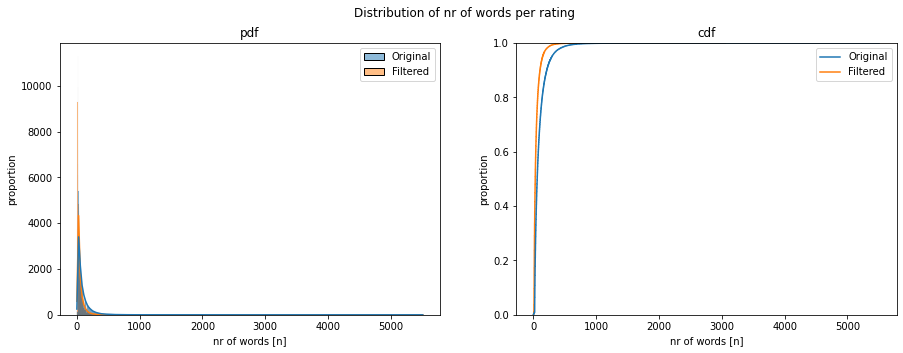

Quantiles of nr of words per rating:
      Original  Filtered
0.00       0.0       0.0
0.25      32.0      16.0
0.50      60.0      29.0
0.75     119.0      58.0
1.00    5508.0    3058.0

Mean word count per rating:
Original    97.273988
Filtered    47.808014
dtype: float64


In [15]:

sentence_length = df_rating[["reviewText", "word_tokens"]]
sentence_length["word_tokens"] = sentence_length["word_tokens"].apply(str.split).apply(len)
sentence_length["reviewText"] = sentence_length["reviewText"].apply(str.split).apply(len)
sentence_length = sentence_length.rename(columns={"reviewText":"Original", "word_tokens":"Filtered"})

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(sentence_length, kde=True, ax=axes[0])
sns.ecdfplot(sentence_length, ax=axes[1])
fig.suptitle("Distribution of nr of words per rating")
axes[0].set_title("pdf")
axes[1].set_title("cdf")
axes[0].set_xlabel("nr of words [n]")
axes[1].set_xlabel("nr of words [n]")
axes[0].set_ylabel("proportion")
axes[1].set_ylabel("proportion")
plt.show()

print("Quantiles of nr of words per rating:")
print(sentence_length.quantile([0, .25, .5, .75, 1]))
print("\nMean word count per rating:")
print(sentence_length.mean())

**Beschreibung:** Die Visualisierungen beschreiben die Länge der Bewertungen vor und nach der Bereinigung bis und mit Lemmatisierung. Beim Betrachten der Visualisierung und der Quantile wird erkennbar, dass  die Anzahl an Wörtern pro Bewertung durch das Preprocessing deutlich reduziert wurde. So konnten wir die durchschnittliche Wortanzahl pro Bewertung halbieren. Auch die Quantile der Satzlängen sind nun jeweils bei ca. 50 Prozent des jeweils vorherigen Wertes.

### 2.6 Train Test Split

Nach dem bereinigen der Daten werden diese nun in ein Trainings und Testset untertilt.

In [16]:
random.seed(mc1seed)

# lemmatized dataset split
X_train, X_test, y_train, y_test = train_test_split(df_rating["word_tokens"], df_rating["category_binary"], test_size=0.25, random_state=30)
print("Train:", X_train.shape, y_train.shape,"Test: ",(X_test.shape,y_test.shape))

# not lemmatized dataset split
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(df_rating["word_tokens_not_lemmatized"], df_rating["category_binary"], test_size=0.25, random_state=30)

Train: (113430,) (113430,) Test:  ((37810,), (37810,))


In [17]:
#balanced testset
y_test_balanced = y_test.groupby(y_test.values, group_keys=False).apply(lambda x: x.sample(min(y_test.value_counts())))
X_test_balanced = X_test.loc[y_test_balanced.index]

### 2.7 TF-IDF with N-gramm

Für uns ist es relevant zu wissen, wie relevant einzelne Wörter innerhalb unserer Bewertungen sind, um dadurch bessere Klassifikationen zu erreichen. Eine Möglichkeit das zu erreichen ist mittels TF-IDF oder term frequency-inverse document frequency. Die Term Frequenz (TF) beschreibt dabei die Proportion eines Terms `t` gegenüber allen Wörtern in einem Dokument `d`. Wörter werden also relevanter, je öfters sie in einem Dokument vorkommen. Die Inverse Dokument Frequenz (IDF) beschreibt dagegen die Proportion der Dokumente, welche den Term `t` beinhalten. Wörter, die in vielen Dokumenten vorkommen, werden dadurch im Score abgeschwächt gegenüber Wörtern, welche nur in wenigen anderen Bewertungen verwendet werden.

Die Formel lautet :    $$tf-idf(t, d) = tf(t, d) * \log{\frac{N}{df(t) + 1}}$$



Legende
- `t`: Term
- `d`: Dokument 
- `N`: Anzahl Dokumente
- `df(t)`: Dokument Frequenz

**Sklearn spezifische Parameter:**
Mit sklearn's `TfidfVectorizer` können wir aus einem Pandas DataFrame eine tf-idf Matrix zu erstellen. Die Methode bietet zusätzlich noch weitere nützliche Argumente. Die Verwendeten sind nachträglich kurz erklärt:

- `ngram_range` erlaubt es zusätzlich noch die Kombination von N-Gramms zu bestimmen. Dadurch können auch Wortkombinationen berücksichtigt werden. Mit einem grösseren N-Gramm Umfang wächst jedoch auch die Anzahl an Features stark an.
- `min_df` erlaubt es Wörter, welche nicht in einer minimalen Anzahl an Dokumenten vorkommen, zu ignorieren. Dadurch kann die Anzahl Features/Dimensionen in der tf-idf Matrix nochmals deutlich verringert werden.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

#set seed 
random.seed(mc1seed)

# Monogramm not lemmatised
vectorizer= TfidfVectorizer(ngram_range=(1, 1), min_df=10)
tfidf_X_train_mono = vectorizer.fit_transform(X_train_nl)
tfidf_X_test_mono = vectorizer.transform(X_test_nl)

# Bigramm not lemmatised
vectorizer= TfidfVectorizer(ngram_range=(1, 2), min_df=10)
tfidf_X_train_bi = vectorizer.fit_transform(X_train_nl)
tfidf_X_test_bi = vectorizer.transform(X_test_nl)

# Trigramm  not lemmatised
vectorizer= TfidfVectorizer(ngram_range=(1, 3), min_df=10)
tfidf_X_train_tri = vectorizer.fit_transform(X_train_nl)
tfidf_X_test_tri = vectorizer.transform(X_test_nl)

# Monogramm lemmatized
vectorizer= TfidfVectorizer(ngram_range=(1, 1), min_df=10)
tfidf_X_train_mono_l = vectorizer.fit_transform(X_train)
tfidf_X_test_mono_l = vectorizer.transform(X_test)

# Bigramm lemmatized
vectorizer= TfidfVectorizer(ngram_range=(1, 2), min_df=10)
tfidf_X_train_bi_l = vectorizer.fit_transform(X_train)
tfidf_X_test_bi_l = vectorizer.transform(X_test)

# Trigramm lemmatized
vectorizer= TfidfVectorizer(ngram_range=(1, 3), min_df=10)
tfidf_X_train_tri_l = vectorizer.fit_transform(X_train)
tfidf_X_test_tri_l = vectorizer.transform(X_test)

print("Nr. of features with 1-gramm:", tfidf_X_train_mono.shape[1])
print("Nr. of features with 2-gramm:", tfidf_X_train_bi.shape[1])
print("Nr. of features with 3-gramm:", tfidf_X_train_tri.shape[1])

Nr. of features with 1-gramm: 15751
Nr. of features with 2-gramm: 75736
Nr. of features with 3-gramm: 85575


Wir haben nun sechs verschiedene Feature-Matrizen erhalten. Diese bestehen aus den N-Gramm Kombinationen (1),  (1 & 2) und (1 & 2 & 3) für jeweils den lemmatisierten und nicht lemmatisierten Datensatz.

## 3.0 Model 1 : Support Vector Machine

Als Nächstes nutzen wir unsere Feature-Matrizen, um mittels Support-Vector-Machine eine binäre Klassifikation der Bewertungen zu trainieren.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

def show_confusion_matrix(y_train, y_test, y_train_pred, y_test_pred, title):
    '''Visualizes the Confusion matrix for a train and testset'''
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle(title)
    ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax[0])
    ax[0].set_title("Confusion matrix of training set")
    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax[1])
    ax[1].set_title("Confusion matrix of training set")
    plt.show()

### 3.1 Model Training & Classification

Nachfolgend werden die Modelle Trainiert. Um das Missverhältnis von positiven und negativen Bewertungen zu berücksichtigen, geschieht das Training mit balancierten Klassengewichten.

In [20]:
random.seed(mc1seed)

# Change target labels to strings since LinearSVC can work with strings, and it is easier for interpretation
# not lemmatized dataset
y_train_svm = y_train_nl.apply(lambda x: "Positive" if x==1 else "Negative")
y_test_svm = y_test_nl.apply(lambda x: "Positive" if x==1 else "Negative")
# lematized dataset
y_train_svm_l = y_train.apply(lambda x: "Positive" if x==1 else "Negative")
y_test_svm_l = y_test.apply(lambda x: "Positive" if x==1 else "Negative")

clf_ = dict()

# train models with monogramm on not lemmatized dataset
clf_["mono"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["mono"].fit(tfidf_X_train_mono, y_train_svm)

# train models with bigramm on not lemmatized dataset
clf_["bi"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["bi"].fit(tfidf_X_train_bi, y_train_svm)

# train models with trigramm on not lemmatized dataset
clf_["tri"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["tri"].fit(tfidf_X_train_tri, y_train_svm)


# train models with monogramm on lemmatized dataset
clf_["mono_lem"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["mono_lem"].fit(tfidf_X_train_mono_l, y_train_svm_l)

# train models with bigramm on lemmatized dataset
clf_["bi_lem"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["bi_lem"].fit(tfidf_X_train_bi_l, y_train_svm_l)

# train models with trigramm on lemmatized dataset
clf_["tri_lem"] = LinearSVC(random_state=0, class_weight="balanced") # balanced class weights
clf_["tri_lem"].fit(tfidf_X_train_tri_l, y_train_svm_l)


# predict on trainset
# not lemmatized
y_train_pred_mono = clf_["mono"].predict(tfidf_X_train_mono)
y_train_pred_bi = clf_["bi"].predict(tfidf_X_train_bi)
y_train_pred_tri = clf_["tri"].predict(tfidf_X_train_tri)

# lemmatized
y_train_pred_mono_l = clf_["mono_lem"].predict(tfidf_X_train_mono_l)
y_train_pred_bi_l = clf_["bi_lem"].predict(tfidf_X_train_bi_l)
y_train_pred_tri_l = clf_["tri_lem"].predict(tfidf_X_train_tri_l)


# prediction on testset
# lemmatized
y_test_pred_mono = clf_["mono"].predict(tfidf_X_test_mono)
y_test_pred_bi = clf_["bi"].predict(tfidf_X_test_bi)
y_test_pred_tri = clf_["tri"].predict(tfidf_X_test_tri)

# lemmatized
y_test_pred_mono_l = clf_["mono_lem"].predict(tfidf_X_test_mono_l)
y_test_pred_bi_l = clf_["bi_lem"].predict(tfidf_X_test_bi_l)
y_test_pred_tri_l = clf_["tri_lem"].predict(tfidf_X_test_tri_l)

### 3.2 Model Interpretation

#### 3.2.1 Interpretation SVM-Classifier with tf_idf and Monogramm on not lemmatized dataset.

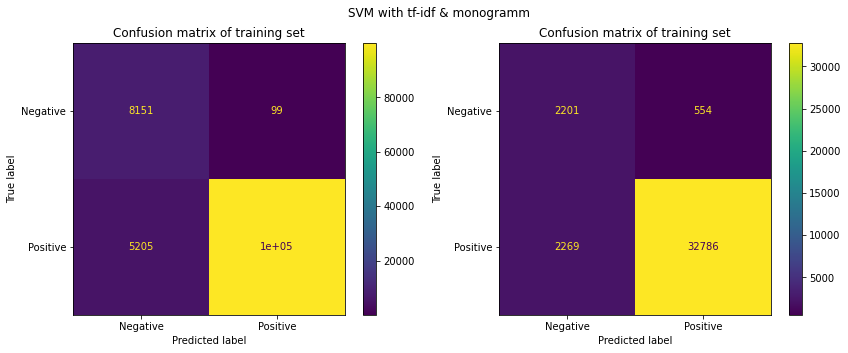

Classification report for SVM classifier with tf-idf and monogramm
              precision    recall  f1-score   support

    Negative       0.49      0.80      0.61      2755
    Positive       0.98      0.94      0.96     35055

    accuracy                           0.93     37810
   macro avg       0.74      0.87      0.78     37810
weighted avg       0.95      0.93      0.93     37810



In [21]:
show_confusion_matrix(y_train_svm, y_test_svm, y_train_pred_mono, y_test_pred_mono, "SVM with tf-idf & monogramm")
print("Classification report for SVM classifier with tf-idf and monogramm")
print(classification_report(y_test_svm, y_test_pred_mono))

**Beschreibung:** Mit der Klassifikation mittels Monogrammen auf dem nicht lemmatisierten Datensatz erhalten wir einen balancierten F1-Score: `macro avg` von 0.78 im Testset. Dabei fällt auf, dass die Precision für die negativen Bewertungen nur bei 0.49 liegt. Das ist einerseits auf die Unausgewogenheit des Testsets zurückzuführen, da durch die vielen positiven Labels auch die fälschlich negativ klassifizierten Samples steigen. Andererseits ist auch der Recall bei den negativen Bewertungen auf nur 0.8, was darauf hindeutet, dass unser Modell trotz balanciertem Training die negativen Bewertungen schlechter klassifizieren kann.

#### 3.2.2 Interpretation SVM-Classifier with tf_idf and Bigramm on not lemmatized dataset.

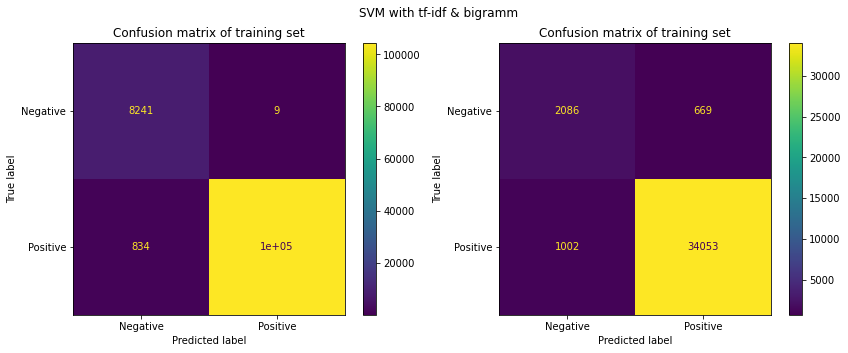

Classification report for SVM classifier with tf-idf and bigramm
              precision    recall  f1-score   support

    Negative       0.68      0.76      0.71      2755
    Positive       0.98      0.97      0.98     35055

    accuracy                           0.96     37810
   macro avg       0.83      0.86      0.85     37810
weighted avg       0.96      0.96      0.96     37810



In [22]:
show_confusion_matrix(y_train_svm, y_test_svm, y_train_pred_bi, y_test_pred_bi, "SVM with tf-idf & bigramm")
print("Classification report for SVM classifier with tf-idf and bigramm")
print(classification_report(y_test_svm, y_test_pred_bi))

**Beschreibung:** Mit der Klassifikation mittels der Inklusion von Bigramm verbessert sich unser balancierter F1-Score: `macro avg` von um 0.07 auf 0.85. Das liegt daran, dass vom Modell nun weniger positive Bewertungen als negativ eingestuft werden, was zu einer deutlichen Verbesserung der Precision auf 0.68 und des F1-Scores auf 0.71 für die Klassifizierung der negativen Bewertungen führt. Auch der F1-Score für die positiven Bewertungen hat sich verbessert und liegt nun bei 0.98. 

#### 3.2.3 Interpretation SVM-Classifier with tf_idf and Trigramm on not lemmatized dataset.

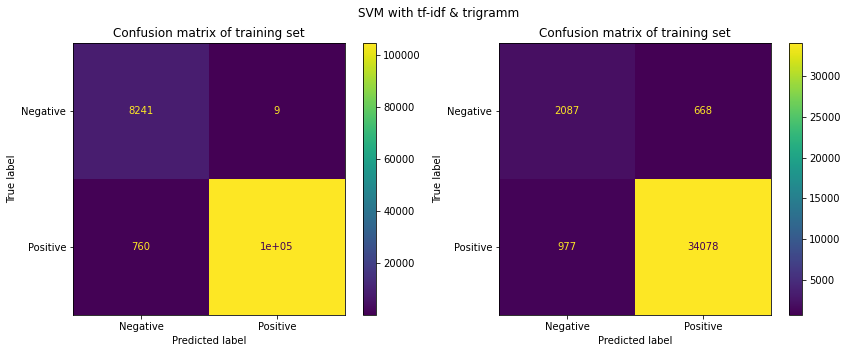

Classification report for SVM classifier with tf-idf and trigramm
              precision    recall  f1-score   support

    Negative       0.68      0.76      0.72      2755
    Positive       0.98      0.97      0.98     35055

    accuracy                           0.96     37810
   macro avg       0.83      0.86      0.85     37810
weighted avg       0.96      0.96      0.96     37810



In [23]:
show_confusion_matrix(y_train_svm, y_test_svm, y_train_pred_tri, y_test_pred_tri, "SVM with tf-idf & trigramm")
print("Classification report for SVM classifier with tf-idf and trigramm")
print(classification_report(y_test_svm, y_test_pred_tri))

**Beschreibung:** Wir sehen, dass die zusätzliche Inklusion von Trigrammen keine signifikante Verbesserung des balancierten F1-Scores: `macro avg` mehr erbringt. Entsprechend sehen wir die Inklusion von Trigrammen zur Klassifikation unserer Daten als nicht notwendig an.

#### 3.2.4 Interpretation SVM-Classifier with tf_idf and Monogramm on lemmatized dataset.

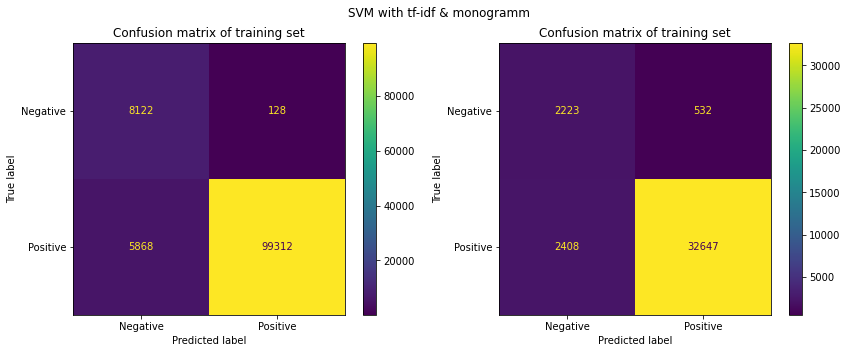

Classification report for SVM classifier with tf-idf and monogramm
              precision    recall  f1-score   support

    Negative       0.48      0.81      0.60      2755
    Positive       0.98      0.93      0.96     35055

    accuracy                           0.92     37810
   macro avg       0.73      0.87      0.78     37810
weighted avg       0.95      0.92      0.93     37810



In [24]:
show_confusion_matrix(y_train_svm_l, y_test_svm_l, y_train_pred_mono_l, y_test_pred_mono_l, "SVM with tf-idf & monogramm")
print("Classification report for SVM classifier with tf-idf and monogramm")
print(classification_report(y_test_svm_l, y_test_pred_mono_l))

**Beschreibung:** Mit der Klassifikation mittels Monogrammen auf dem lemmatisierten Datensatz erhalten wir einen balancierten F1-Score: `macro avg` von 0.78 im Testset und ist identisch zum Wert, welcher mit der nicht lemmatisierten Variante erreicht wurde. Generell scheint der Klassifikationsreport beim Vergleich der beiden Modelle (Monogramm mit und ohne Lemmatisierung) relativ ähnlich, sodass wir keine eindeutige Verbesserung oder Verschlechterung der Klassifikation feststellen können. 

#### 3.2.5 Interpretation SVM-Classifier with tf_idf and Bigramm on lemmatized dataset.

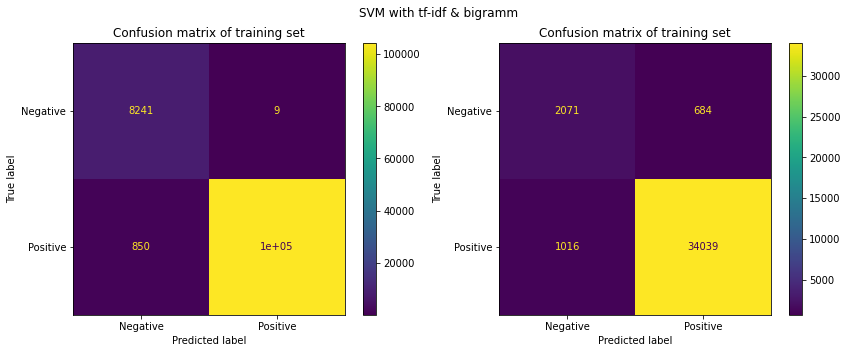

Classification report for SVM classifier with tf-idf and bigramm
              precision    recall  f1-score   support

    Negative       0.67      0.75      0.71      2755
    Positive       0.98      0.97      0.98     35055

    accuracy                           0.96     37810
   macro avg       0.83      0.86      0.84     37810
weighted avg       0.96      0.96      0.96     37810



In [25]:
show_confusion_matrix(y_train_svm_l, y_test_svm_l, y_train_pred_bi_l, y_test_pred_bi_l, "SVM with tf-idf & bigramm")
print("Classification report for SVM classifier with tf-idf and bigramm")
print(classification_report(y_test_svm_l, y_test_pred_bi_l))

**Beschreibung:** Mit der Klassifikation mittels Bigrammen auf dem lemmatisierten Datensatz erhalten wir wieder dasselbe Verhalten wie beim nicht lemmatisierten Datensatz. Auch hier erhalten wir eine Verbesserung von 0.06 beim F1-Score im Vergleich zur Version, welche nur Monogramme verwendet. Beim Vergleich mit dem nicht lemmatisierten Datensatz sehen wir nur minimale Unterschiede in der Klassifikationsgüte, so hat sich der macro avg F1-Score um 1 Prozent verschlechtert. Somit ist keine Verbesserung erkennbar.

#### 3.2.6 Interpretation SVM-Classifier with tf_idf and Trigramm on lemmatized dataset.

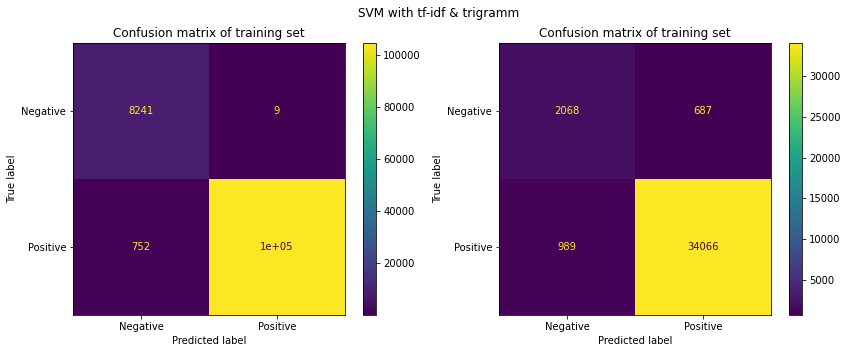

Classification report for SVM classifier with tf-idf and trigramm
              precision    recall  f1-score   support

    Negative       0.68      0.75      0.71      2755
    Positive       0.98      0.97      0.98     35055

    accuracy                           0.96     37810
   macro avg       0.83      0.86      0.84     37810
weighted avg       0.96      0.96      0.96     37810



In [26]:
show_confusion_matrix(y_train_svm_l, y_test_svm_l, y_train_pred_tri_l, y_test_pred_tri_l, "SVM with tf-idf & trigramm")
print("Classification report for SVM classifier with tf-idf and trigramm")
print(classification_report(y_test_svm_l, y_test_pred_tri_l))

**Beschreibung:** Und zuletzt erhalten wir mit der Klassifikation mittels Inklusion von Trigrammen auf dem lemmatisierten Datensatz einen macro avg F1-Score von 0.84. Somit bringt auch beim lemmatisierten Datensatz die Inklusion von Trigrammen verglichen mit Bigrammen keine Verbesserung mehr.

### 3.3 Balkendiagramm mit Modelvergleich

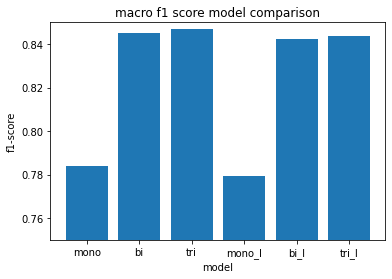

In [27]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

score_df = pd.DataFrame()

predictions = {
    "mono":y_test_pred_mono,
    "bi":y_test_pred_bi,
    "tri":y_test_pred_tri,
    "mono_l":y_test_pred_mono_l,
    "bi_l":y_test_pred_bi_l,
    "tri_l":y_test_pred_tri_l
    }

for k in predictions:
    score_df.loc[k, "balanced_accuracy_score"] = balanced_accuracy_score(y_test_svm, predictions[k])
    score_df.loc[k, "accuracy_score"] = accuracy_score(y_test_svm, predictions[k])
    score_df.loc[k, "macro_f1_score"] = f1_score(y_test_svm, predictions[k], average="macro")


plt.bar(score_df.index, score_df["macro_f1_score"])
plt.ylim(0.75,0.85)
plt.title("macro f1 score model comparison")
plt.ylabel("f1-score")
plt.xlabel("model")
plt.show()

**Beschreibung:** 

`_l` bezeichnet die lemmatisierten Datensätze.

Die Visualisierung zeigt den macro F1-Score für unsere sechs Modelle. Es fällt auf, dass die Lemmatisierung des Datensatzes keinen deutlichen Unterschied im F1-Score herbeigeführt hat. (vgl. `mono` und `mono_l`). Mit der Erhöhung der N-Gramm Range ist hingegen eine Verbesserung erkennbar. So bringt die Inklusion von Bigramms (`bi` und `bi_l`) beim lemmatisierten Datensatz als auch beim nicht lemmatisierten Datensatz eine Verbesserung von ca. 6 Prozentpunkten. Die Erweiterung mit Trigramms (`bi` und `bi_l`) bringt hingegen nur noch eine minimale Verbesserung unter 0.5 Prozent. Die Verbesserung des F1-Scores ist hier generell darauf zurückzuführen, dass die Erhöhung der N-Gramm Range dazu führt, dass die Modelle die negativen Labels besser klassifizieren.

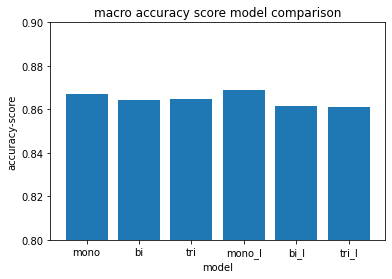

In [28]:
plt.bar(score_df.index, score_df["balanced_accuracy_score"], )
plt.ylim(0.8,0.9)
plt.title("macro accuracy score model comparison")
plt.ylabel("accuracy-score")
plt.xlabel("model")
plt.show()

**Beschreibung:** Der macro Accuracy-Score schwankt über die einzelnen Modelle deutlich weniger. So befindet dieser sich immer zwischen 0.86 und 0.87. Interessanterweise scheint die inklusion von Bi- und Trigramms die Accuracy hier sogar leicht zu verschlechtern. 

## 4.0 CNN for Sentinentanals

Ein Covolutional Neuronal Network (CNN) ist eine Erweiterung des Deep Neural Networks (DNN). Es ist in der Lage, Muster  in den Features zu erkennen. Dies geschieht mittels sogenannten Convolutionale Layer, welche dem Netz seinen Namen geben, und anschliessenden Pooling Layer. Diese Konstellation aus Convolutional Layer und Pooling Layer kann mehrfach wiederholt werden, um auch komplexere Muster zu erkennen. Der output wird anschliessend in einen eindimensionalen Vektor umgewandelt und durch das DNN in eine Wahrscheinlichkeit für die Zugehörigkeit einer Klasse umgewandelt. Der Input für unser Embedding Layer wird durch eine one-hot encodiere 2 dimensionale Matrix erzeugt. Bei CNN's ist es ausserdem relevant, dass unser Input jeweils identische Dimensionen aufweist. Dies geschieht mittels Padding. Beim Padding kann eine fixe Inputdimensionen definiert werden, wobei Sätze mit weniger Featuredimensionen einfach mit Nullen erweitert werden.

In unserem Fall wählen wir dafür die durchschnittliche Anzahl von Wörtern, die in einem Satz vorkommen.
Da diese Berechnung bei vielen Daten lange dauert, wird dies mit einem Dask Dataframe berechnet, weil so das arithmetische Mittel von mehreren CPU Cores parallel berechnet werden kann. `max_lengt` ist hier unser erster Hyperparameter.

Ein weiterer Hyperparameter ist die `vocab_size`, welche auch als Input Parameter für das Embedding benötigt wird. Wir haben hier den Wert von 21'000 von der n-gramm Analyse abgeleitet.

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### 4.1 Preprocessing

In [30]:
df_fast = dd.from_pandas(df_rating[["word_tokens"]],npartitions=4)
max_length = int(df_fast["word_tokens"].str.split().map(lambda x:len(x)).compute().mean())
hyper = {"num_epochs":10,
         "vocab_size":21000,
         "emb_dim" : 100,
         "max_length": max_length,
         "filter_conv1":32,
         "kernelsize_conv1":4,
         "aktiv_conv1":"relu",
         "kernelsize_maxP1":4,
         "dropout1": 0.4,
         "dropout2": 0.4,
         "dnn1_output": 100,
         "dnn1_aktiv":"relu",
         "dnn2_output":10,
         "dnn2_aktiv":"relu",
         "output":1,
         "output_aktiv":"sigmoid",
         }

In [31]:
# Preprocessing
#lenght for Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

#padding
docs = X_train.to_list()
encoded_docs = [one_hot(d, hyper["vocab_size"]) for d in docs]
X_train_p = pad_sequences(encoded_docs, maxlen=max_length)

docs = X_test.to_list()
encoded_docs_test = [one_hot(d, hyper["vocab_size"]) for d in docs]
X_test_p = pad_sequences(encoded_docs_test, maxlen=max_length)

#### 4.1.1 Plot CNN-Model Funktion
Als Metrik für den fit des CNN-Models verwenden wir die Accuracy. TODO

In [32]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_accuracy']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

### 4.2 Model mit Keras
Als Framework für das CNN benutzen wir Keras. Mit Keras kann man sehr einfach CNN erstellen, trainieren und evaluieren.
Die Struktur unseres CNN sieht wie folgt aus:
1. Embedding der die Input daten möglichst gut auf 100 Dimensionen fitten kann.
2. Convolution Layer mit einer Kernel Grösse von 4, Anzahl Filter 32 und einer Aktivierungsfunktion Relu.
3. 1D MaxPooling für die Komprimierung Filter, es wird der durchschnittliche Wert von einem 4*4 Grid genommen.
4. Dropout mit einer Wahrscheinlichkeit von P = 0.5; in einem Dropout Layer wird während des Trainings in jedem Step zufällige Neuron "stumm geschalten". So ist das Netzwerk gezwungen, zu generalisieren.
5. Nun wird der n-dimensional Vektor auf eine Dimension herunter-konkateniert, sodass er als Input für das DNN genutzt werden kann.
6. Der erste Layer des DNN hat 100 Output-Dimensionen, die Input-Dimension wird von Keras automatisch berechnet.
7. Der Hidden Layer des DNN ist nicht unbedingt notwendig, er bildet den Zwischenschritt, zwischen Input und Output im DNN. Beide DNN Layer werden mit einer Relu Aktivierungsfunktion implementiert.
8. Der Output-layer ist ein einzelnes Neuron, welches mit einer Sigmoidfunktion aktiviert wird. Das heisst, der Output ist ein Wert zwischen 0 und 1 und gibt eine Art Wahrscheinlichkeit wieder. Das Ergebnis des Output-Layers kann wie das Ergebnis einer logistischen Regression verstanden werden.


Aus diesem Aufbau ergeben sich einige Hyperparameter, die für Qualität des Ergebnisses alle einen Einfluss haben.
1. Embedding: `vocab_size`,`max_lenght`, `emb_dim`
2. Conv1D : `filter_conv1`,`kernelsize_conv1`,`aktiv_conv1`
3. MaxPool : `kernelsize_maxP1`
4. Dropout : `dropout1`,`dropout2`
5. DNN : `dnn1_output`, `dnn2_output`, `output`

In [33]:
import keras
class convnet:
    @staticmethod
    def create_convnet(hyper):
        tf.random.set_seed(mc1seed)
        input_shape = layers.Input(shape=(hyper["max_length"],))
        emb = layers.Embedding(hyper["vocab_size"], hyper["emb_dim"],)(input_shape)
        conv = layers.Conv1D(filters=hyper["filter_conv1"], kernel_size=hyper["kernelsize_conv1"],activation=hyper["aktiv_conv1"])(emb)
        maxpool = layers.MaxPooling1D(pool_size=hyper["kernelsize_maxP1"])(conv)
        dropout = layers.Dropout(hyper["dropout1"])(maxpool)
        flat = layers.Flatten()(dropout)
        out1 = layers.Dense(hyper["dnn1_output"],activation=hyper["dnn1_aktiv"])(flat)
        out2 = layers.Dropout(hyper["dropout2"])(out1)
        out3 = layers.Dense(hyper["dnn2_output"],activation=hyper["dnn2_aktiv"])(out2)
        out4= layers.Dense(hyper["output"],activation=hyper["output_aktiv"])(out3)
        return keras.Model(input_shape, out4)

In [34]:
con_cnn = convnet()
model_cnn = con_cnn.create_convnet(hyper)
print(model_cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 47, 100)           2100000   
_________________________________________________________________
conv1d (Conv1D)              (None, 44, 32)            12832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               35300 

Die Anzahl Layer des CNN, als auch des DNN, sind selbst auch ein Hyperparameter. Dies überschreitet allerdings den Scope dieser Arbeit, da wir nicht alle möglichen CNN Architekturen ausprobieren können. Die Zusammenfassung des Netzwerkes zeigt, dass das Netzwerk aus c.a 2,1 Millionen Parametern besteht. Die zufällig initialisiert werden und im Training optimiert werden. Auch in diesem Abschnitt gibt es wieder Hyperparameter, jedoch nicht so viele. Die Anzahl Trainingsepochen ist im eigentlichen kein Hyperparameter, allerdings sollte man das Modell nehmen, dass einen möglichst kleinen Validations besitzt. Das Model wird nach dem Erreichen des besten Validierung-Loss nur noch schlechter werden, es overfitted. Also wollen wir das Modell mit vielen Epochen trainieren, um zu sehen, ab wann es overfitted. Für Overfitting haben wir die Dropoutlayer eingefügt, es ist allerdings unabdingbar, dass das Modell ab einem bestimmten Zeitpunkt nur noch overfitted. Ein weiterer wichtiger Hyperparameter beim Training ist die Batch-size. Die Batch-size hat einen direkten Einfluss auf die Effektivität der Lerninserate.
Als Lossfuktion verwenden wir die binäre-Crossentropy und als optimizer verwenden wir den Adam Optimizer.

In [35]:
hyper["batch_size"]=128
hyper["loss"]= "binary_crossentropy"
hyper["opt"] = "adam"

In [36]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [37]:
model_cnn.compile(loss = hyper["loss"],
                  optimizer = hyper["opt"],
                  metrics = ["accuracy",
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             get_f1])

history_cnn = model_cnn.fit(X_train_p, y_train,
                        epochs=hyper["num_epochs"],
                        verbose=True,
                        validation_data=(X_test_p, y_test),
                        batch_size=hyper["batch_size"],
                        )

Epoch 1/10
887/887 [==============================] - 22s 14ms/step - loss: 0.1786 - accuracy: 0.9379 - precision: 0.9434 - recall: 0.9926 - get_f1: 0.9673 - val_loss: 0.1479 - val_accuracy: 0.9464 - val_precision: 0.9483 - val_recall: 0.9966 - val_get_f1: 0.9717
Epoch 2/10
887/887 [==============================] - 11s 13ms/step - loss: 0.1203 - accuracy: 0.9556 - precision: 0.9653 - recall: 0.9876 - get_f1: 0.9763 - val_loss: 0.1388 - val_accuracy: 0.9499 - val_precision: 0.9566 - val_recall: 0.9908 - val_get_f1: 0.9733
Epoch 3/10
887/887 [==============================] - 12s 13ms/step - loss: 0.0910 - accuracy: 0.9666 - precision: 0.9752 - recall: 0.9891 - get_f1: 0.9820 - val_loss: 0.1507 - val_accuracy: 0.9482 - val_precision: 0.9583 - val_recall: 0.9871 - val_get_f1: 0.9724
Epoch 4/10
887/887 [==============================] - 12s 13ms/step - loss: 0.0636 - accuracy: 0.9773 - precision: 0.9841 - recall: 0.9916 - get_f1: 0.9878 - val_loss: 0.1801 - val_accuracy: 0.9468 - val_prec

In [38]:
import operator
max_index, max_value = max(enumerate(history_cnn.history["val_accuracy"]), key=operator.itemgetter(1))
print(f'Test Accuracy: {round((max_value*100),4)} % \nIn Epoch Nr.{max_index+1}')

Test Accuracy: 94.9881 % 
In Epoch Nr.2


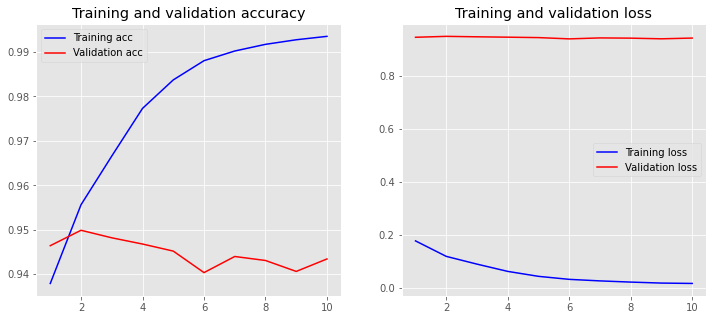

In [39]:
# plot history
plot_history(history_cnn)

#### 4.2.1 CNN-Model Evaluation
Wir sehen, dass das Model eine Train-Accuarcy von 99,4% erreicht. Was bedeutet, dass das Model die Daten sehr gut wiedergeben kann. Ein anderer Punkt jedoch ist die Test Accuracy, welche sich zwar auf 95% befindet, jedoch nicht besser wird. Das Model ist overfitted. Das sehen wir auch sehr gut am Loss Plot. Der Trainloss hat eine schöne Kurve, der Testloss jedoch bleib konstant schlecht. Für Overfitting haben wir zwei Dropouts mit p=0.4 engebaut. Dies ist sogar ein recht grosser Dropout, dennoch overfitted das Model stark. Dennoch ist die Testaccuracy von 95% nicht zu verachten.

### 4.3 Gridsearch
Bei der Methodenwahl zur Hyperparameter Optimierung stehen verschiedene Strategien zur Verfügung. Eine wäre, alle möglichen Kombinationen der Hyperparameter zu testen (Gridsearch). Die Variante  ist  mehrheitlich dann sinnvoll, wenn unter den Hyperparametern eine gegenseitige Abhängigkeit vermutet wird.  Mit Itertools kann sehr einfach alle möglichen Kombinationen der Hyperparameter generiert werden. Doch bei 8 Hyperparameter und 4 Möglichkeiten ergibt das insgesamt 4^8 (65536) Kombinationen. Bei einer Trainingszeit von 10 Minuten pro Kombination ergibt das eine gesamte Trainingsdauer von 241 Jahren. Dies ist definitiv zu lange.  Wir vermuten zudem keine Abhängigkeit zwischen den meisten Hyperparameter. Aus diesem Grund werden die Hyperparameter getrennt optimiert. 

In [40]:
params = {"vocab_size":[hyper["vocab_size"],10000,5000,1000],
                "emb_dim" : [100,200,300,400],
                "max_length": [20,30,40,hyper["max_length"]],
                "filter_conv1":[16,32,64,128],
                "kernelsize_conv1":[2,4,8,16],
                "kernelsize_maxP1":[2,4,8,16],
                "dropout1": [0.4,0.5,0.6,0.7],
                "dropout2": [0.4,0.5,0.6,0.7],
                "dnn1_output": [50,100,200,500],
                "dnn2_output":[6,10,20,30],
                }

In [41]:
from itertools import product
# unused code: all combinations of unique dicionaries ; 65536
dicta = {}
perm = product('ABCD', repeat=8)
for i in list(perm):
    if i in dicta:
        dicta[i] += 1
    else:
        dicta[i] = 1

### 4.3.1 Preprocessing Hyperparameters

In [42]:
def train_model(model,hyper,X_train_p,y_train,X_test_p,y_test):
    model.compile(loss = hyper["loss"],
                  optimizer = hyper["opt"],
                  metrics = ["accuracy",
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             get_f1])


    history = model.fit(X_train_p, y_train,
                            epochs=hyper["num_epochs"],
                            verbose=True,
                            validation_data=(X_test_p, y_test),
                            batch_size=hyper["batch_size"],
                            )
    return history

In [43]:
# hyperloop XD
if run_gridsearch:
    besties = {}
    for key in params.keys():
        print("---------------------")
        print(f"| checkout {key} |")
        print("---------------------\n")
        templist = []
        for i in params[key]:
            print("---------------------")
            print(f"| with {key}={i} |")
            print("---------------------")
            hyper_c = hyper.copy()
            hyper_c[key]= i
            con = convnet()
            model = con.create_convnet(hyper_c)
            #padding has to be done different
            if key == "max_length":
                X_train_pr = pad_sequences(encoded_docs, maxlen=i)
                X_test_pr = pad_sequences(encoded_docs_test, maxlen=i)
                h = train_model(model,hyper_c,X_train_pr,y_train,X_test_pr,y_test)
            else :
                h = train_model(model,hyper_c,X_train_p,y_train,X_test_p,y_test)
            max_index, max_value = max(enumerate(h.history["val_accuracy"]), key=operator.itemgetter(1))
            templist.append(round(max_value,4)*100)
        besties[key]= params[key][templist.index(max(templist))]

In [44]:
# das überabeitete Hyperparameter Dictionary kann nun im nächsten Schritt verwendet werden.
if run_gridsearch:
    hyper_new = {"vocab_size":besties["vocab_size"],
                 "emb_dim" : besties["emb_dim"],
                 "max_length": besties["max_length"],
                 "filter_conv1":besties["filter_conv1"],
                 "kernelsize_conv1":besties["kernelsize_conv1"],
                 "aktiv_conv1":"relu",
                 "kernelsize_maxP1":besties["kernelsize_maxP1"],
                 "dropout1": besties["dropout1"],
                 "dropout2": besties["dropout2"],
                 "dnn1_output": besties["dnn1_output"],
                 "dnn1_aktiv":"relu",
                 "dnn2_output":besties["dnn2_output"],
                 "dnn2_aktiv":"relu",
                 "output":1,
                 "output_aktiv":"sigmoid"
                 }
else:
    hyper_new = {'vocab_size': 21000,
                 'emb_dim': 200,
                 'max_length': 47,
                 'filter_conv1': 128,
                 'kernelsize_conv1': 4,
                 'aktiv_conv1': 'relu',
                 'kernelsize_maxP1': 2,
                 'dropout1': 0.4,
                 'dropout2': 0.5,
                 'dnn1_output': 500,
                 'dnn1_aktiv': 'relu',
                 'dnn2_output': 20,
                 'dnn2_aktiv': 'relu',
                 'output': 1,
                 'output_aktiv': 'sigmoid'}

Dem Hyperparametertuning nach ist die optimale embedding grösse 200 Features. Der Rest ist grösstenteils gleich geblieben, die vocabsize, die maxlengt und auch die dropouts. Mit dem Maximalwert von 128 Filter für den CNN Layer ist die Performance scheinbar am besten, was erst logisch erscheint, da mehr Filter auch mehr Features extrahieren können. Es ist allerdings die Frage, wie viel besser das Model tatsächlich ist. Ein Blick in den Log des Gridsearches zeigt, bei einer 32 Filtern ist die Test-Accuracy bereits bei 0.9396, bei 128 0.9467. Das ist zwar eine Verbesserung, jedoch ist es auch ressourcenaufwendig mehr Filter zu benutzen. Dies trifft auch auf die Maxpooling Proportion zu, welche sehr klein gehalten wurde.

In [45]:
con_new = convnet()
model_new = con_new.create_convnet(hyper_new)

In [46]:
X_test_p.shape

(37810, 47)

In [47]:
model_new.compile(loss = hyper["loss"],
                  optimizer = hyper["opt"],
                  metrics = ["accuracy",
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.Recall(),
                             get_f1])


history_new = model_new.fit(X_train_p, y_train,
                                epochs=hyper["num_epochs"],
                                verbose=True,
                                validation_data=(X_test_p, y_test),
                                batch_size=hyper["batch_size"],
                                )

Epoch 1/10
887/887 [==============================] - 16s 16ms/step - loss: 0.1626 - accuracy: 0.9418 - precision_1: 0.9481 - recall_1: 0.9915 - get_f1: 0.9693 - val_loss: 0.1336 - val_accuracy: 0.9516 - val_precision_1: 0.9554 - val_recall_1: 0.9942 - val_get_f1: 0.9743
Epoch 2/10
887/887 [==============================] - 15s 16ms/step - loss: 0.1014 - accuracy: 0.9621 - precision_1: 0.9714 - recall_1: 0.9882 - get_f1: 0.9797 - val_loss: 0.1354 - val_accuracy: 0.9517 - val_precision_1: 0.9638 - val_recall_1: 0.9850 - val_get_f1: 0.9741
Epoch 3/10
887/887 [==============================] - 13s 15ms/step - loss: 0.0568 - accuracy: 0.9793 - precision_1: 0.9859 - recall_1: 0.9919 - get_f1: 0.9888 - val_loss: 0.1744 - val_accuracy: 0.9482 - val_precision_1: 0.9637 - val_recall_1: 0.9811 - val_get_f1: 0.9722
Epoch 4/10
887/887 [==============================] - 60s 67ms/step - loss: 0.0276 - accuracy: 0.9901 - precision_1: 0.9937 - recall_1: 0.9957 - get_f1: 0.9947 - val_loss: 0.2230 - val

Test Accuracy: 95.17 % 
In Epoch Nr.2


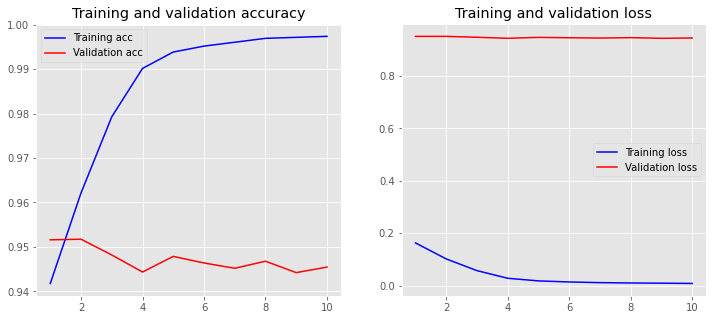

In [48]:
max_index, max_value = max(enumerate(history_new.history["val_accuracy"]), key=operator.itemgetter(1))
print(f'Test Accuracy: {round(max_value, 4) * 100} % \nIn Epoch Nr.{max_index + 1}')
# plot history
plot_history(history_new)

Wir sehen, dass das Modell sich gleich verhält, als vor dem Gridsearch. Die performance hat sich um c.a 0.03 gesteigert. Wir kommen so auch 95,27 % Test Accuracy.

### 4.4 CNN Tower System
CNN können je nach initialisierungswert andere Accuracies erreichen. Um dem entgegenzuwirken, kann man sogenannte CNN Tower erstellen. Diese sind sozusagen parallele CNN, die auch unterschiedlich initialisiert werden.

In [49]:
class tower_cnn:
    @staticmethod
    def create_convnet(hyper):
        tf.random.set_seed(mc1seed)

        input_shape = layers.Input(shape=(hyper["max_length"],))

        emb = layers.Embedding(hyper["vocab_size"], hyper["emb_dim"],)(input_shape)

        tower_1 = layers.Conv1D(filters=hyper["filter_conv1"], kernel_size=hyper["kernelsize_conv1"], activation=hyper["aktiv_conv1"])(emb)
        tower_1 = layers.MaxPooling1D(pool_size=hyper["kernelsize_maxP1"])(tower_1)
        tower_1 = layers.Dropout(hyper["dropout1"])(tower_1)

        tower_2 = layers.Conv1D(filters=hyper["filter_conv1"], kernel_size=hyper["kernelsize_conv1"], activation=hyper["aktiv_conv1"])(emb)
        tower_2 = layers.MaxPooling1D(pool_size=hyper["kernelsize_maxP1"])(tower_2)
        tower_2 = layers.Dropout(hyper["dropout1"])(tower_2)

        tower_3 = layers.Conv1D(filters=hyper["filter_conv1"], kernel_size=hyper["kernelsize_conv1"], activation=hyper["aktiv_conv1"])(emb)
        tower_3 = layers.MaxPooling1D(pool_size=hyper["kernelsize_maxP1"])(tower_3)
        tower_3 = layers.Dropout(hyper["dropout1"])(tower_3)

        merged = layers.concatenate([tower_1, tower_2, tower_3], axis=1)
        merged = layers.Flatten()(merged)

        out1 = layers.Dense(100, activation='relu')(merged)
        out2 = layers.Dropout(hyper["dropout2"])(out1)
        out3 = layers.Dense(10, activation='relu')(out2)
        out4= layers.Dense(1, activation='sigmoid')(out3)

        return keras.Model(input_shape, out4)

In [50]:
con_tower = tower_cnn()
model_tower = con_tower.create_convnet(hyper)

In [51]:
model_tower.compile(loss = hyper["loss"],
                    optimizer = hyper["opt"],
                    metrics = ["accuracy",
                               tf.keras.metrics.Precision(),
                               tf.keras.metrics.Recall(),
                               get_f1])

history_tower = model_tower.fit(X_train_p, y_train,
                    epochs=hyper["num_epochs"],
                    verbose=True,
                    validation_data=(X_test_p, y_test),
                    batch_size=hyper["batch_size"],
                    )

Epoch 1/10
887/887 [==============================] - 24s 21ms/step - loss: 0.1770 - accuracy: 0.9380 - precision_2: 0.9444 - recall_2: 0.9915 - get_f1: 0.9671 - val_loss: 0.1448 - val_accuracy: 0.9485 - val_precision_2: 0.9516 - val_recall_2: 0.9951 - val_get_f1: 0.9728
Epoch 2/10
887/887 [==============================] - 18s 20ms/step - loss: 0.1130 - accuracy: 0.9583 - precision_2: 0.9675 - recall_2: 0.9882 - get_f1: 0.9777 - val_loss: 0.1355 - val_accuracy: 0.9528 - val_precision_2: 0.9632 - val_recall_2: 0.9868 - val_get_f1: 0.9747
Epoch 3/10
887/887 [==============================] - 15s 17ms/step - loss: 0.0788 - accuracy: 0.9706 - precision_2: 0.9787 - recall_2: 0.9899 - get_f1: 0.9842 - val_loss: 0.1545 - val_accuracy: 0.9500 - val_precision_2: 0.9619 - val_recall_2: 0.9851 - val_get_f1: 0.9732
Epoch 4/10
887/887 [==============================] - 15s 17ms/step - loss: 0.0470 - accuracy: 0.9830 - precision_2: 0.9885 - recall_2: 0.9932 - get_f1: 0.9908 - val_loss: 0.1896 - val

Test Accuracy: 95.28 % 
In Epoch Nr.2


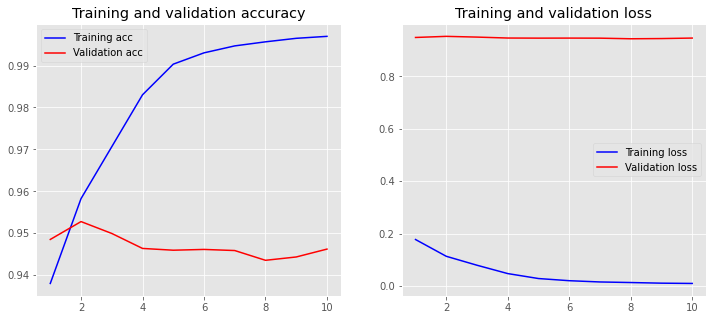

In [52]:
max_index, max_value = max(enumerate(history_tower.history["val_accuracy"]), key=operator.itemgetter(1))
print(f'Test Accuracy: {round(max_value, 4) * 100} % \nIn Epoch Nr.{max_index + 1}')
# plot history
plot_history(history_tower)

#### 4.4.1 CNN-Tower System Evaluierung
Das Model verhält sich gleich. Die Test Accuracy ist sogar gesunken. Vermutlich hatten wir ohne den Tower ein wenig Glück. Das Model ist nicht wirklich schlechter geworden und es ist definitiv stabiler.

### 4.5 Genaue Analyse der Verteilung der Metriken
Wir haben in unserem Training des Models bisher nur die Accuracy als Metrik betrachtet. Zu genaueren betrachtung der Metriken des Endresultates wollen wir uns die Metriken Recall, Precision und F1 anschauen.

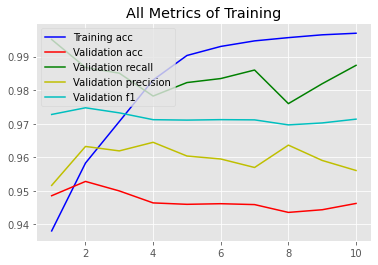

In [53]:
def plot_history_all(hi):
    acc = hi.history['accuracy']
    val_acc = hi.history['val_accuracy']
    val_rec = hi.history['val_recall_2']
    val_pre = hi.history['val_precision_2']
    val_f1 = hi.history['val_get_f1']
    x = range(1, len(acc) + 1)

    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.plot(x, val_rec, 'g', label='Validation recall')
    plt.plot(x, val_pre, 'y', label='Validation precision')
    plt.plot(x, val_f1, 'c', label='Validation f1')
    plt.title('All Metrics of Training')
    plt.legend()
    plt.show()

plot_history_all(history_tower)

**Beschreibung:** Wir sehen, dass der F1 Score sich nicht sehr stark verändert. Anders jedoch der Recall und Precision. Es ist sehr interessant, wie man sieht, dass Recall und Precision sich spiegeln und das Mittel dieser Keven bildet dann der F1. Der F1 erreicht einen Wert über 97 % was sehr gut ist. Die Test Accuracy ist zwar mit 95 % schlechter, was aber auch auf das unbalanced Datenset zurückzuführen ist. Zusätzlich lernt das Modell schon nach 2 Epochen, das beste Ergebnis. Allerdings wurde das Model auch mit dem Adam Optimizer trainiert.

### 4.6 Fehleranalyse 

Da auch unser bestes CNN Modell nicht fehlerlos ist, wollen wir nun Stichprobenhaft untersuchen, wie die falsch klassifizierten Labels aussehen und überprüfen, ob systematische Fehler vorliegen.

In [54]:

def is_fp(y, y_hat):
    '''
    calculates false positives.
    Args: 
        y: true values
        y_hat: predicted values
    Returns:
        fp: false positives
    '''
    fp = ((y_hat == 1) & (y == 0))
    return fp

def is_fn(y, y_hat):
    '''
    calculates false negatives.
    Args: 
        y: true values
        y_hat: predicted values
    Returns:
        fn: false negatives
    '''
    fn = ((y_hat == 0) & (y == 1))
    return fn

# get predictions
y_pred_p = model_tower.predict(X_test_p)
fn_id = X_test[is_fn(y_test.to_numpy(), np.around(y_pred_p, 0).reshape(1,-1)[0])].index.values
fp_id = X_test[is_fp(y_test.to_numpy(), np.around(y_pred_p, 0).reshape(1,-1)[0])].index.values

Zuerst schauen wir uns negative Bewertungen an, welche fälschlicherweise als Positiv eingestuft wurden.

In [55]:
for i in fp_id[0:5]:
    print("-------------------------------------------------------------------------------------------")
    print("Text:", df["reviewText"][i])
    print("Original rating:", df["overall"][i])

-------------------------------------------------------------------------------------------
Text: My kids see a commercial for some great new tablet and start the begging and pleading for it even though they already have a VReader and already have an Inotab and already have whatever else was popular last week, but these became available and I figured, why not.  I might as well dip in and see if they are worth snagging.I have some issues.I&#8217;m tired of these tablets pretending to be these great learning tools when their games are pretty standard generic and cheap and don&#8217;t really compel the mind to dig deeper.  I mean, they can&#8217;t hold the interest of a child because they don&#8217;t challenge the mind and they only repeat a series of tasks that are essentially pretty boring.  So, as a learning tool, I don&#8217;t see the appeal here.  What is provided on the actual tablet is minuscule (like, two games) but the games available for purchase (none of the aps are free, sadly

Und nun noch positive Bewertungen an, welche con unserem Modell fälschlicherweise als Negativ eingestuft wurden.

In [56]:
for i in fn_id[0:5]:
    print("-------------------------------------------------------------------------------------------")
    print("Text:", df["reviewText"][i])
    print("Original rating:", df["overall"][i])

-------------------------------------------------------------------------------------------
Text: My 9-year-old grandson saw this and wanted it.  I questioned how much he would use it because he spends all his free time playing computer games, but I got it thinking that assembling this would help him improve his small muscle coordination, which is a problem for him.The problem is that once the game was assembled and played with for a short time, he was back to his computer games, which are a lot more exciting.  I doubt it will be played with again, and many of the small pieces will be lost.There is nothing wrong  with the game, but it does not compete with the computer games that he plays.I don't think he is unusual in this respect, and for that reason I don't recommend it for children that are avid computer game players.When I was a child, a game like this would have been a big deal.  But that was long before we had computers.
Original rating: 4
---------------------------------------

**Beschreibung:** 

Bei den fehlerhaften Klassifikationen sehen wir, dass diese oft Wörter beinhalten, welche für uns isoliert betrachtet, eine starke Positive oder Negative Assoziation haben. 

- Text: *My 9-year-old grandson saw this and wanted it.  I questioned how much he would use it because he spends all his free time playing computer games, but I got it thinking that assembling this would help him improve his small muscle coordination, which is a problem for him.The problem is that once the game was assembled and played with for a short time, he was back to his computer games, which are a lot more exciting.  I doubt it will be played with again, and many of the small pieces will be lost.There is nothing wrong  with the game, but it does not compete with the computer games that he plays.I don't think he is unusual in this respect, and for that reason I don't recommend it for children that are avid computer game players. When I was a child, a game like this would have been a big deal.  But that was long before we had computers.*
<br>Original rating: *4*

    Bei dieser Bewertung wurden viele negativ assoziierte Wörter verwendet wie problem, short, doubt, lost, wrong, don't, was vermutlich den Ausschlag gegeben hat für die negative Klassifikation. Die eigentliche Bewertung ist jedoch positiv.

<br>
Eine andere Fehlerquelle ist bei Text, welcher sich nicht auf das zu bewertende Produkt bezieht. 

- Text: *Great game. Please don't make us write all these words.  It keeps you from getting reviews.  I cannot spend this much time.* 
<br> Original rating: *5*

    Hier liegt zum Beispiel eine Beschwerde zum Bewertungssystem vor und nicht zum Produkt, welches mit 5 Sternen sehr gut bewertet wurde. Unser Modell hat die Bewertung aufgrund des Textes entsprechend als negativ eingestuft.

<br>
Es gibt jedoch auch Bewertungen, bei denen wir nicht genau erkennen können, weshalb hier unser Modell eine falsche Klassifikation vorgenommen hat. Allenfalls könnte die Struktur des CNN's noch optimiert werden.

- Text: *Pieces are very small and do not fit well together, in spite of some carving and sanding by us.  Several times during attempted construction, the model "exploded" into pieces.  Not well engineered at all.  Very frustrating for my granddaughter, aged 10, and me, aged 64.  I am an experienced modeler, with a bench of modeler's tools.  Could only get the motor to turn by placing the solar panel directly against a very strong light.The four and five star reviews here are nonsense.  I do not believe these people actually bought and (attempted) to make this model.  Very disappointing.*
<br>Original rating: *1*

    Hier ist für uns zum Beispiel nicht genau erkennbar, weshalb unser CNN die Bewertung positiv klassifiziert hat. Generell sehen die falsch klassifizierten Bewertungen jedoch überdurchschnittlich lange aus. Wir wollen dies nun überprüfen und vergleichen die Quantile der falsch klassifizierten Samples und dem kompletten Datensatz. 

In [57]:
q = X_test.apply(str.split).apply(len).quantile([0, .25, .5, .75, 1])
fn_q = X_test[fn_id].apply(str.split).apply(len).quantile([0, .25, .5, .75, 1])
fp_q = X_test[fp_id].apply(str.split).apply(len).quantile([0, .25, .5, .75, 1])

pd.DataFrame({"complete dataset":q, "false positives":fp_q, "false negatives":fn_q})

,complete dataset,false positives,false negatives
0.00,0.0,0.0,7.0
0.25,16.0,22.0,22.0
0.50,29.0,43.0,45.0
0.75,58.0,86.0,87.0
1.00,1778.0,1115.0,1727.0


**Beschreibung:** Das Dataframe zeigt die Quantile der Anzahl an Wörtern in unseren Bewertungen nach dem Bereinigen. Nun bestätigt sich unsere Vermutung, dass die Quantile der falsch klassifizierten Samples tatsächlich deutlich höhere Werte aufweisen, als das beim kompletten Datensatz der Fall ist. So haben die Hälfte der fälschlicherweise als negativ klassifizierten Bewertungen 42 oder mehr Wörter, bei den  fälschlicherweise als positiv klassifizierten Bewertungen sind es sogar 43. Im kompletten Datensatz ist der Median bei der Anzahl Wörtern pro Bewertung jedoch nur bei 29. 

### 5.0 Zusammenfassung

Das beste Support-Vector Machine Modell, mit einem F1-Score von 0.847, ist jenes welches auf dem nicht lematisierten Datensatz und er Bildung von Trigrammen trainiert wurde. Die relative Verbesserung zwischen der Inklusion von Trigrammen gegenüber der Varianten, welche nur bis Bigrammen geht, ist jedoch sehr minimal. Das könnte daran liegen, dass mit Bigrammen häufige Wortkombinationen wie Negationen (not) oder Gradpartikel wie (very, little) welche die Grundbedeutung einer Bewertung beeinflussen können. Dagegen gibt es jedoch verhältnismässig wenige 3-Wortkombinationen mit demselben Effekt.
 Unser bestes CNN Modell war sogar in der Lage einen F1-Score von 0.975 zu erreichen. Es kann also ein deutlicher Unterschied in der Performance zwischen CNN und SVM festgestellt werden. Wir vermuten, dass diese Steigerung teilweise auf den Embedding-Layer zurückzuführen ist, da dieser durch die Dimensionsreduktion bereits ein Mapping zwischen den Wörtern trainiert."m